In [1]:
import LinearAlgebra
import Plots as plt

include("../lib/test_functions.jl")
import .TestFunctions: ackley

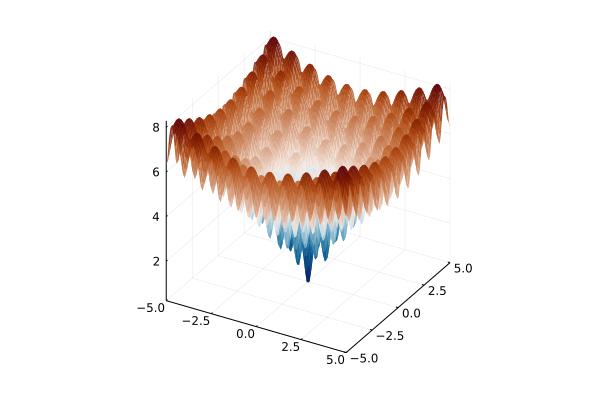

In [2]:
f = ackley(10.0)

xdomain = LinRange(-5, 5, 100)
ydomain = LinRange(-5, 5, 100)

plt.surface(xdomain, ydomain, (x, y) -> f([x, y]); opacity=0.9, colorbar=false, fill=(true, plt.cgrad(:vik)))

In [3]:
using Distributions
using Random

function logarithmic_annealing_schedule(t0::Number)
  return (k::Int64) -> t0 * log(2) / log(k + 1)
end

function exponential_annealing_schedule(t0::Number, γ::Float64=0.85)
  tk = t0
  return (k::Int64 = 0) -> tk *= γ
end

function fast_annealing_schedule(t0::Number)
  return (k::Int64) -> t0 / k
end

function simple_simulated_annealing(
  f::Function,
  x0::Vector{Float64},
  transition_distribution::ContinuousUnivariateDistribution,
  temperature_schedule::Function;
  max_iter::Int64=20,
  max_traces=1e3
)
    x, y = x0, f(x0)
    x_best, y_best = x, y
    dim = length(x0)
    traces = []
    trace_step_size = ceil(max_iter / max_traces)
    push!(traces, x)
    for iter in 1:max_iter
      x_next = x + rand(transition_distribution, dim)
      y_next = f(x_next)
      Δy = y_next - y
      if Δy <= 0 || rand() < exp(-Δy/temperature_schedule(iter)) 
        x, y = x_next, y_next
      end
      if y_next < y_best
        x_best, y_best = x_next, y_next
      end
      if iter % trace_step_size == 0
        push!(traces, x_next)
      end
    end
    push!(traces, x_best)
    return x_best, y_best, traces
end

simple_simulated_annealing (generic function with 1 method)

Optimum: x=[0.0, 0.0001]; f=0.00015117112786855458

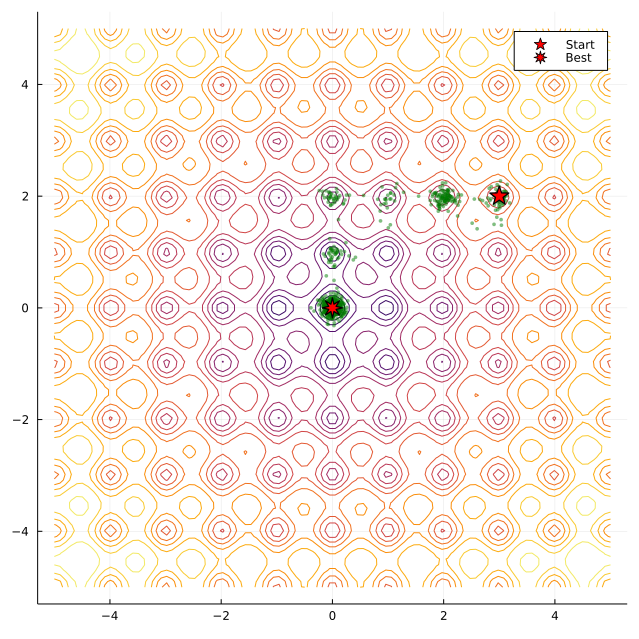

In [4]:
Random.seed!(2)

annealing_schedule = logarithmic_annealing_schedule(5.0)
# annealing_schedule = exponential_annealing_schedule(1e5, 0.9999)
# annealing_schedule = fast_annealing_schedule(5e4)

# transition_distribution = Uniform(-2e-2, 2e-2)
transition_distribution = Normal(0, 2e-2)

x, y, traces = simple_simulated_annealing(
  f,
  [3.0, 2.0],
  transition_distribution,
  annealing_schedule,
  max_iter=Int64(1e5),
  max_traces=1e3
)
print("Optimum: x=$(round.(x, digits=4)); f=$y")
plot = plt.contour(xdomain, ydomain, (x, y) -> f([x, y]); colorbar=false, size=(640, 640))
plt.scatter!(plot, [p[1] for p in traces], [p[2] for p in traces]; markersize=2, markeralpha=0.5, markerstrokewidth=0, markercolor=:green, label="")
plt.scatter!(plot, [3], [2]; markershape=:star1, markersize=10, markerstrokewidth=1, markercolor=:red, label="Start")
plt.scatter!(plot, [x[1]], [x[2]]; markershape=:star2, markersize=10, markerstrokewidth=1, markercolor=:red, label="Best")